Notebook to generate data file that is a subset of the SGA catalog with rotational velocities measured during EDR (fuji).

In [1]:
import numpy as np

from astropy.table import Table, join
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as const

from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
c = const.c.to_value('km/s')

q0 = 0.2

# Redrock systematic duplicate redshift uncertainty (from Lan+23)
dv_sys = 7 # km/s
dz_sys = dv_sys/c

# Data

## fuji

In [3]:
tfuji = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/desi_pv_tf_fuji_healpix.fits')
#tfuji = Table.read('/Users/kellydouglass/Documents/Research/data/DESI/SV/desi_pv_tf_fuji_healpix.fits')
tfuji[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195


### Update all Redrock uncertainties to account for 7 km/s statistical uncertainty

In [4]:
tfuji['ZERR_MOD'] = np.sqrt(tfuji['ZERR']**2 + dz_sys**2)

### Are $\sigma_z$ small relative to $z$?

In [5]:
np.max(tfuji['ZERR_MOD']/tfuji['Z'])

18.759439752055748

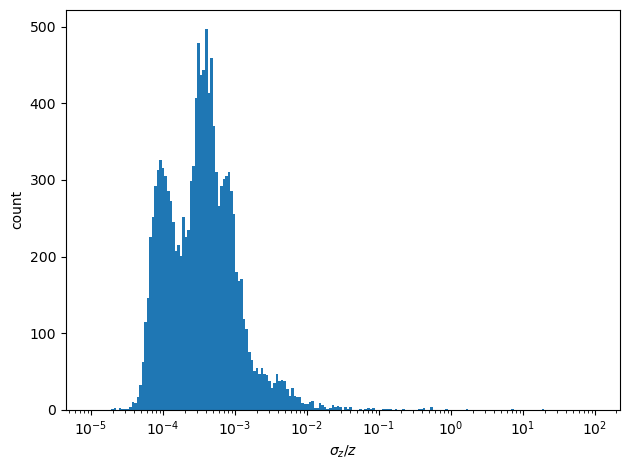

In [6]:
plt.figure(tight_layout=True)

plt.hist(tfuji['ZERR_MOD']/tfuji['Z'], bins=np.logspace(-5, 2, 200))

plt.xscale('log')

plt.xlabel(r'$\sigma_z/z$')
plt.ylabel('count');

## SGA

In [7]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
#SGA = Table.read('/Users/kellydouglass/Documents/Research/data/SGA/SGA-2020.fits', 'ELLIPSE')

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

In [8]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

# Separate the fuji data into center and off-center observations

In [9]:
tfuji['SKY_FIBER_DIST'] = 0.
tfuji['SKY_FIBER_DIST_R26'] = 0.

# For each SGA galaxy that has at least one observation, calculate the distance 
# for all of that galaxy's targets
for sga_id in tqdm(np.unique(tfuji['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = tfuji['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center of the SGA 
    # galaxy
    #---------------------------------------------------------------------------
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                          dec=SGA['DEC'][sga_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tfuji['RA'][obs_idx], 
                             dec=tfuji['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(SGA_coords)
    
    tfuji['SKY_FIBER_DIST'][obs_idx] = sep2d
    tfuji['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------

100%|██████████| 4524/4524 [00:13<00:00, 342.25it/s]


In [10]:
centers_boolean = tfuji['SKY_FIBER_DIST_R26'] < 0.1

fuji_centers = tfuji[centers_boolean]
fuji_axis = tfuji[~centers_boolean]

## Clean the fuji center observations

Only keep those with
* `DELTACHI2` > 25
* `ZWARN` == 0

In [11]:
good_centers = fuji_centers[(fuji_centers['DELTACHI2'] > 25) & (fuji_centers['ZWARN'] == 0)]

### How does $\sigma_z$ compare with $z$ for the good center observations?

In [12]:
print(np.max(good_centers['ZERR_MOD']/good_centers['Z']), np.max(fuji_axis['ZERR_MOD']/fuji_axis['Z']))

0.5409130078069039 18.759439752055748


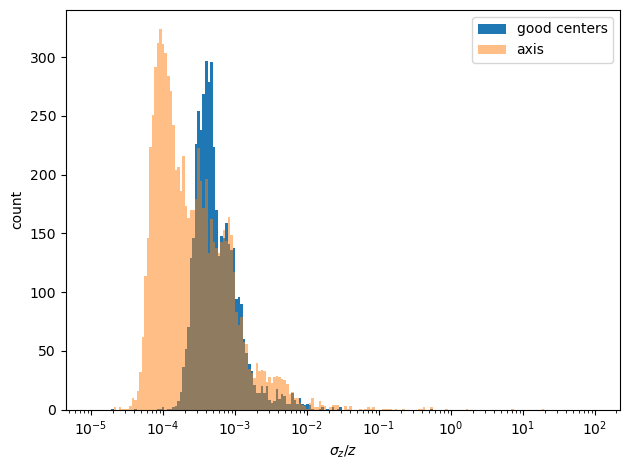

In [13]:
plt.figure(tight_layout=True)

plt.hist(good_centers['ZERR_MOD']/good_centers['Z'], bins=np.logspace(-5, 2, 200), label='good centers')
plt.hist(fuji_axis['ZERR_MOD']/fuji_axis['Z'], bins=np.logspace(-5, 2, 200), alpha=0.5, label='axis')

plt.xscale('log')

plt.legend()

plt.xlabel(r'$\sigma_z/z$')
plt.ylabel('count');

### Are there any galaxies with multiple good center observations?

In [14]:
unique_ids, counts = np.unique(good_centers['SGA_ID'], return_counts=True)

print(unique_ids[counts > 1], counts[counts > 1])

 SGA_ID
-------
    848
   3727
   6443
  10959
  12318
  16649
  26199
  28451
  37543
  46327
    ...
1363936
1364394
1365198
1366241
1374698
1380792
1382772
1386484
1392414
1401610
1418640
Length = 175 rows [2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


## If an SGA galaxy has at least one observation at its center, set the redshift of that galaxy

In [15]:
rng = np.random.default_rng()

N_samples = 10000 # for large error propagation

In [16]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

# weights = 1./(good_centers['ZERR']**2)
weights = 1./(good_centers['ZERR_MOD']**2)

for sga_id in tqdm(np.unique(good_centers['SGA_ID'])):
    
    # Find all the center observations of this galaxy
    obs_idx = good_centers['SGA_ID'] == sga_id
    N_obs = np.sum(obs_idx)
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the weighted average redshift of all 
    # good center observations
    SGA['Z_DESI'][SGA_idx] = np.average(good_centers['Z'][obs_idx], 
                                        weights=weights[obs_idx])

    if N_obs == 1 or np.all(np.abs(good_centers['ZERR_MOD'][obs_idx]/good_centers['Z'][obs_idx]) < 0.05):
        SGA['ZERR_DESI'][SGA_idx] = np.sqrt(1./(N_obs*np.sum(weights[obs_idx])))
    else:
        z_random = np.zeros((N_obs, N_samples))

        for i in range(N_obs):
            z_random[i] = rng.normal(scale=good_centers['ZERR_MOD'][obs_idx][i], 
                                     loc=good_centers['Z'][obs_idx][i], 
                                     size=N_samples)
        
        avg_z_random = np.average(z_random, 
                                  weights=weights[obs_idx,None]*np.ones(N_samples), 
                                  axis=0)
        SGA['ZERR_DESI'][SGA_idx] = np.std(avg_z_random)

100%|██████████| 4255/4255 [00:01<00:00, 4063.09it/s]


In [17]:
print(good_centers['Z', 'ZERR', 'ZERR_MOD'][good_centers['SGA_ID'] == 848])
print(SGA['Z_DESI', 'ZERR_DESI'][SGA['SGA_ID'] == 848])

        Z                  ZERR                ZERR_MOD       
------------------ -------------------- ----------------------
0.0699433547367303 9.06362424382781e-06 2.5046912222858453e-05
0.0699116031710255 2.72330650976674e-05  3.587252935158132e-05
       Z_DESI             ZERR_DESI       
------------------- ----------------------
0.06993294860406668 1.4521420716863818e-05


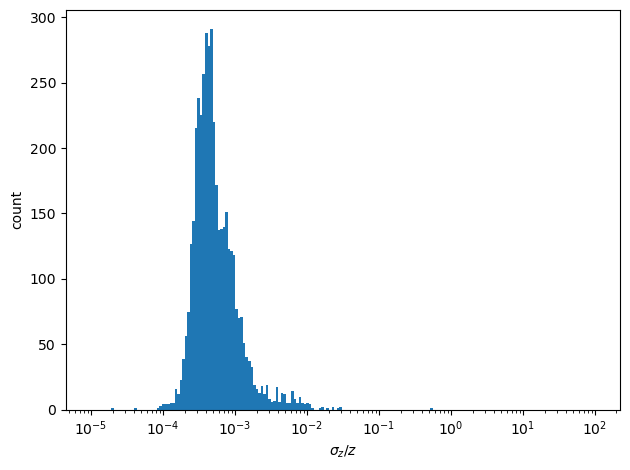

In [18]:
plt.figure(tight_layout=True)

plt.hist(SGA['ZERR_DESI']/SGA['Z_DESI'], bins=np.logspace(-5, 2, 200))

plt.xscale('log')

plt.xlabel(r'$\sigma_z/z$')
plt.ylabel('count');

# Calculate the rotational velocity

In [19]:
fuji_axis['V_ROT'] = np.nan
fuji_axis['V_ROT_ERR'] = np.nan

# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in tqdm(np.unique(good_centers['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = fuji_axis['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]

    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = SGA['Z_DESI'][sga_idx]
    z_err_center = SGA['ZERR_DESI'][sga_idx]

    # Calculate rotational velocity for all observations of the galaxy
    # fuji_axis['V_ROT'][obs_idx] = c.to('km/s')*(fuji_axis['Z'][obs_idx] - z_center)
    z_rot = (1 + fuji_axis['Z'][obs_idx])/(1 + z_center) - 1
    fuji_axis['V_ROT'][obs_idx] = c*z_rot

    # Calculate uncertainty in the rotational velocity
    if np.all(np.abs(fuji_axis['ZERR_MOD'][obs_idx]/fuji_axis['Z'][obs_idx]) < 0.05) and (z_err_center/z_center < 0.05):
        # fuji_axis['V_ROT_ERR'][obs_idx] = c.to('km/s')*np.sqrt(fuji_axis['ZERR'][obs_idx]**2 + z_err_center**2 + (dv_sys/c.to('km/s')).value**2)
        fuji_axis['V_ROT_ERR'][obs_idx] = c*np.sqrt((fuji_axis['ZERR_MOD'][obs_idx]/(1 + z_center))**2 + z_err_center**2*((1 + fuji_axis['Z'][obs_idx])/(1 + z_center)**2))
        # fuji_axis['V_ROT_ERR'][obs_idx] = c*np.sqrt((axis_inComa['ZERR'][obs_idx]/(1 + z_center))**2 + z_err_center**2*((1 + fuji_axis['Z'][obs_idx])/(1 + z_center)**2) + (dv_sys/c).value**2)
    else:
        z_center_random = rng.normal(scale=z_err_center, 
                                     loc=z_center, 
                                     size=N_samples)

        z_axis_random = np.zeros((np.sum(obs_idx), N_samples))

        for i in range(np.sum(obs_idx)):
            z_axis_random[i] = rng.normal(scale=fuji_axis['ZERR_MOD'][obs_idx][i], 
                                          loc=fuji_axis['Z'][obs_idx][i], 
                                          size=N_samples)

        z_rot_random = (1 + z_axis_random)/(1 + z_center_random) - 1

        fuji_axis['V_ROT_ERR'][obs_idx] = np.std(np.abs(c*z_rot_random), axis=1)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    fuji_axis['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

100%|██████████| 4255/4255 [00:02<00:00, 2087.10it/s]


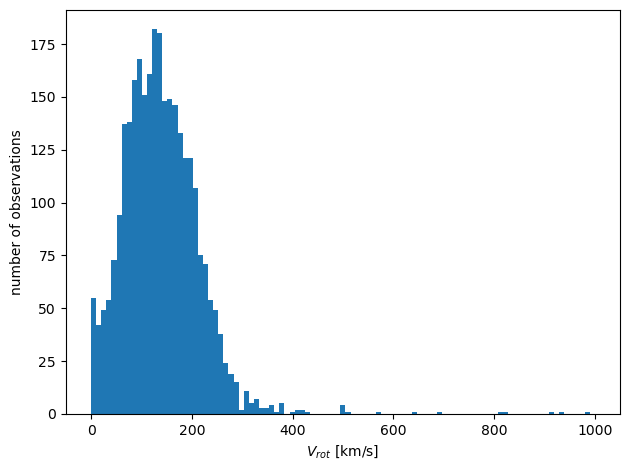

In [20]:
plt.figure(tight_layout=True)

plt.hist(np.abs(fuji_axis['V_ROT']), bins=np.linspace(0, 1000, 100))

plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('number of observations');

# Quality criteria for velocities

Requirements:
* $10 < V_{rot} < 1000$ km/s at $0.33R_{26}$
* $\Delta V / V_{min} \leq 5$

## Velocity cut

In [21]:
r0p3 = (fuji_axis['SKY_FIBER_DIST_R26'] > 0.3) & (fuji_axis['SKY_FIBER_DIST_R26'] < 0.4)

Vgood = (np.abs(fuji_axis['V_ROT']) < 1000) & (np.abs(fuji_axis['V_ROT']) > 10)

good_axis = fuji_axis[r0p3 & Vgood]

print(len(good_axis), len(np.unique(good_axis['SGA_ID'])))

2333 1204


## Relative velocity cut

In [22]:
good_deltaV = np.ones(len(good_axis), dtype=bool)

for sga_id in tqdm(np.unique(good_axis['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_axis['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:
        
        Vmin = np.min(np.abs(good_axis['V_ROT'][obs_idx]))
        Vmax = np.max(np.abs(good_axis['V_ROT'][obs_idx]))
        
        v_norm_min = np.abs(good_axis['V_ROT'][obs_idx])/Vmin
        v_norm_max = np.abs(good_axis['V_ROT'][obs_idx])/Vmax
        
        diff_matrix = np.abs(good_axis['V_ROT'][obs_idx]).reshape(n_obs, 1) - np.abs(good_axis['V_ROT'][obs_idx]).reshape(1, n_obs)
        
        diff_matrix_norm = diff_matrix/Vmin
        
        if np.any(np.abs(diff_matrix_norm) > 5.):
            
            '''
            print(sga_id)
            print(diff_matrix_norm)
            print(1/v_norm_min.data)
            print(v_norm_max.data)
            print(good_axis[['TARGETID', 'V_ROT', 'PVTYPE', 'FILENAME', 'DELTACHI2', 'ZWARN']][obs_idx].pprint(max_width=-1))
            ''';
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            deltachi2_idx = good_axis['DELTACHI2'] >= 25
            
            good_deltaV[obs_idx & ~deltachi2_idx] = False
            
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin = np.min(np.abs(good_axis['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(good_axis['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(good_axis['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin
                
                if np.any(np.abs(diff_matrix_norm) > 5.):
                    '''
                    print(sga_id)
                    print(diff_matrix_norm)
                    print(good_axis[['TARGETID', 'V_ROT', 'PVTYPE', 'FILENAME', 'DELTACHI2', 'ZWARN']][obs_idx].pprint(max_width=-1))
                    ''';
                    # Set all of these so that we don't look at this galaxy
                    good_deltaV[good_obs_idx] = False

100%|██████████| 1204/1204 [00:00<00:00, 4456.48it/s]


In [23]:
good_deltaV_axis = good_axis[good_deltaV]

print(len(good_deltaV_axis), len(np.unique(good_deltaV_axis['SGA_ID'])))

2306 1195


# Compute the weighted average velocity for those galaxies with more than one observation at $0.33R_{26}$

\begin{equation}
  \overline{v} = \frac{\sum_i w_i v_i}{\sum_i w_i}
\end{equation}
where $w_i = 1/\sigma^2$

In [24]:
SGA['V_0p33R26'] = np.nan
SGA['V_0p33R26_ERR'] = np.nan

weights = 1./(good_deltaV_axis['V_ROT_ERR']**2)

for sga_id in np.unique(good_deltaV_axis['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_deltaV_axis['SGA_ID'] == sga_id
    N_obs = np.sum(obs_idx)
    
    SGA['V_0p33R26'][SGA_dict[sga_id]] = np.average(np.abs(good_deltaV_axis['V_ROT'][obs_idx]), 
                                                    weights=weights[obs_idx])

    if N_obs == 1 or np.all(np.abs(good_deltaV_axis['V_ROT_ERR'][obs_idx]/good_deltaV_axis['V_ROT'][obs_idx]) < 0.05):
        SGA['V_0p33R26_ERR'][SGA_dict[sga_id]] = np.sqrt(1./(N_obs*np.sum(weights[obs_idx])))
    else:
        v_random = np.zeros((N_obs, N_samples))

        for i in range(N_obs):
            v_random[i] = rng.normal(scale=good_deltaV_axis['V_ROT_ERR'][obs_idx][i], 
                                     loc=np.abs(good_deltaV_axis['V_ROT'][obs_idx][i]), 
                                     size=N_samples)
        
        v_avg_random = np.average(v_random, 
                                  weights=weights[obs_idx,None]*np.ones(N_samples), 
                                  axis=0)
        SGA['V_0p33R26_ERR'][SGA_dict[sga_id]] = np.std(v_avg_random)

# Save catalog of just those galaxies with EDR velocities

In [25]:
SGA_TF_fuji = SGA[np.isfinite(SGA['V_0p33R26']) & (SGA['R_MAG_SB26'] > 0)]

## Pull in `PHOTSYS` column

In [26]:
photsys = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/SV/SGA-2020_fuji_Vrot_dVsys_photsys.fits')

In [27]:
SGA_TF_fuji_photsys = join(SGA_TF_fuji, photsys['SGA_ID', 'PHOTSYS'], keys='SGA_ID')

## Write final catalog to file

In [28]:
SGA_TF_fuji_photsys.write('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/SV/SGA-2020_fuji_Vrot_dVsys_photsys.fits', 
                          overwrite=True)